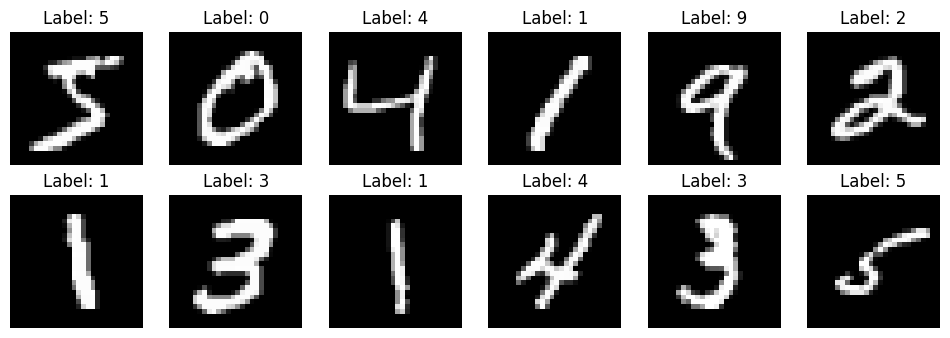

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import torch
import torch.optim as optim
import struct
from torch.utils.data import TensorDataset, DataLoader, random_split
def read_idx_gz(filename):
    with gzip.open(filename, 'rb') as file:
        zero, data_type, dims = struct.unpack('>HBB', file.read(4))
        shape = tuple(struct.unpack('>I', file.read(4))[0] for d in range(dims))
        return np.frombuffer(file.read(), dtype=np.uint8).reshape(shape)

def find_labels(images, labels, target_labels, num_each):
    found = {label: 0 for label in target_labels}
    indices = []

    for i, label in enumerate(labels):
        if label in target_labels and found[label] < num_each:
            indices.append(i)
            found[label] += 1
            if all(found[l] >= num_each for l in target_labels):
                break

    return indices

train_images_content = '/content/train-images-idx3-ubyte.gz'
train_labels_content = '/content/train-labels-idx1-ubyte.gz'
test_images_content = '/content/t10k-images-idx3-ubyte.gz'
test_labels_content = '/content/t10k-labels-idx1-ubyte.gz'

data_train = read_idx_gz(train_images_content)
data_tags = read_idx_gz(train_labels_content)
test_images = read_idx_gz(test_images_content)
test_tags = read_idx_gz(test_labels_content)

plt.figure(figsize=(12, 6))
for i in range(12):
    plt.subplot(3, 6, i + 1)
    plt.imshow(data_train[i], cmap='gray')
    plt.title(f"Label: {data_tags[i]}")
    plt.axis('off')

In [ ]:
train_images = torch.tensor(data_train,dtype=torch.float32)
train_images=train_images/0.5
train_labels = torch.tensor(data_tags,dtype=torch.long)
test_images = torch.tensor(test_images,dtype=torch.float32)
test_images = test_images/0.5
test_labels =  torch.tensor(test_tags,dtype=torch.long)

train_images=train_images.reshape(60000,1,28,28)
train_labels=train_labels.reshape(60000)
test_images=test_images.reshape(10000,1,28,28)
test_labels=test_labels.reshape(10000)


split=int(len(train_images)*0.9)
train_images_s,train_labels_s=train_images[:split],train_labels[:split]
valid_images,valid_labels=train_images[split:],train_labels[split:]

train_dataset = TensorDataset(train_images_s, train_labels_s)
test_dataset = TensorDataset(test_images, test_labels)
valid_dataset = TensorDataset(valid_images, valid_labels)


batch_size = 32


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


len(train_loader),len(test_loader),len(valid_dataset)

(1688, 313, 6000)

In [ ]:
print(train_images.shape,data_tags.shape,test_images.shape,test_tags.shape)
print(train_images.ndim,data_tags.ndim,test_images.ndim,test_tags.ndim)

torch.Size([60000, 1, 28, 28]) (60000,) torch.Size([10000, 1, 28, 28]) (10000,)
4 1 4 1


In [ ]:
def find_batch(roll_number):
    A = int(roll_number[-3:])
    if A % 2 == 0:
        return 32
    elif A % 3 == 0:
        return 16
    else:
        return 20

roll_number = 'p23cs0010'
batch_size = find_batch(roll_number)
print(batch_size)

32


In [ ]:
len(train_loader),len(test_loader)

(1688, 313)

In [ ]:
print(train_images.shape,train_labels.shape,test_images.shape,test_labels.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([60000]) torch.Size([10000, 1, 28, 28]) torch.Size([10000])


In [ ]:
# Define Class for CNN model
import torch.nn as nn
import torch.nn.functional as F
class MYY_CNN(nn.Module):
    def __init__(self, num_classes):
        super(MYY_CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7, stride=1, padding=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc = nn.Linear(4 * 4, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.avgpool(F.relu(self.conv3(x)))
        x = x.view(x.size(0),-1)
        x=self.fc(x)

        return x

In [ ]:
# Create instance
torch.manual_seed(40)
nidhi=MYY_CNN(10)

In [ ]:
# Show Model summary
nidhi

MYY_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=16, out_features=10, bias=True)
)

In [ ]:
def train_and_validate(model, criterion, optimizer, train_loader, validation_loader, epochs):
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss, correct_train, total_train = 0.0, 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        total_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in validation_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        validation_loss = total_loss / len(validation_loader)
        validation_accuracy = 100 * correct_val / total_val
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        print(f"Epoch_no {epoch + 1}/{epochs} - "
              f"Train_Loss: {train_loss:.4f}, Train_Acc: {train_accuracy:.2f}% - "
              f"Validation_Loss: {validation_loss:.4f}, Validation_Acc: {validation_accuracy:.2f}%")

    return train_losses, train_accuracies, validation_losses, validation_accuracies


# DEfine Loss function and Optimization Algo

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nidhi.parameters())

# Replace 'train_loader' and 'validation_loader' with your actual data loaders
train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(nidhi, criterion, optimizer, train_loader, valid_loader, epochs=15)

Epoch_no 1/15 - Train_Loss: 0.5792, Train_Acc: 81.60% - Validation_Loss: 0.1544, Validation_Acc: 95.23%
Epoch_no 2/15 - Train_Loss: 0.1573, Train_Acc: 95.16% - Validation_Loss: 0.0913, Validation_Acc: 97.38%
Epoch_no 3/15 - Train_Loss: 0.1228, Train_Acc: 96.24% - Validation_Loss: 0.1100, Validation_Acc: 96.47%
Epoch_no 4/15 - Train_Loss: 0.1051, Train_Acc: 96.74% - Validation_Loss: 0.0833, Validation_Acc: 97.78%
Epoch_no 5/15 - Train_Loss: 0.0940, Train_Acc: 97.10% - Validation_Loss: 0.0955, Validation_Acc: 97.55%
Epoch_no 6/15 - Train_Loss: 0.0881, Train_Acc: 97.21% - Validation_Loss: 0.0922, Validation_Acc: 97.48%
Epoch_no 7/15 - Train_Loss: 0.0802, Train_Acc: 97.56% - Validation_Loss: 0.0756, Validation_Acc: 97.88%
Epoch_no 8/15 - Train_Loss: 0.0781, Train_Acc: 97.54% - Validation_Loss: 0.0768, Validation_Acc: 97.77%
Epoch_no 9/15 - Train_Loss: 0.0768, Train_Acc: 97.58% - Validation_Loss: 0.0851, Validation_Acc: 97.35%
Epoch_no 10/15 - Train_Loss: 0.0705, Train_Acc: 97.76% - Validat

In [ ]:
def calculate_test_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy

test_accuracy = calculate_test_accuracy(nidhi, test_loader)


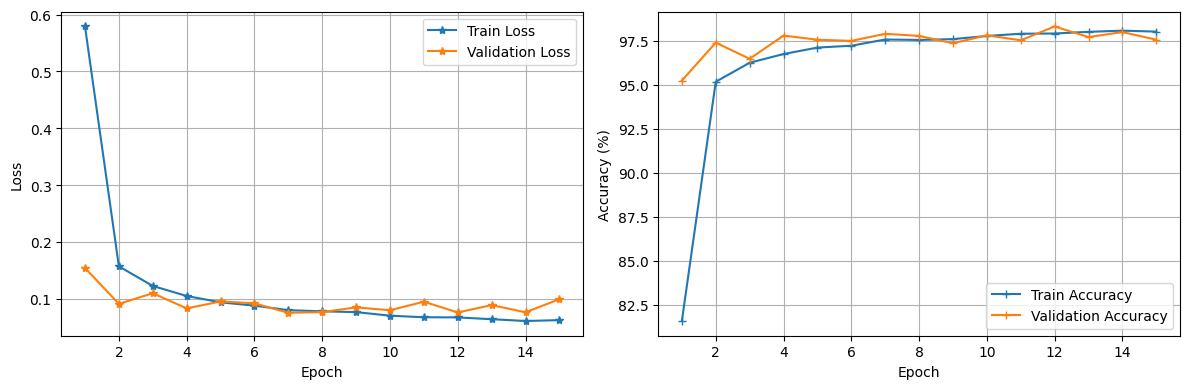

Sample Image Shape from Test Loader: torch.Size([32, 1, 28, 28])


In [ ]:
def analysis_model(model, train_losses, validation_losses, train_accuracies, validation_accuracies, test_loader, epochs):
    # Plotting the training and validation losses and accuracies
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='*')
    plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss', marker='*')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', marker='+')
    plt.plot(range(1, epochs + 1), validation_accuracies, label='Validation Accuracy', marker='+')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    # Displaying a sample image shape from test loader
    images, _ = next(iter(test_loader))
    print(f"Sample Image Shape from Test Loader: {images.shape}")




analysis_model(nidhi, train_losses, validation_losses, train_accuracies, validation_accuracies, test_loader, epochs=15)


In [ ]:
def cal_parameters(model):
    total_params = 0
    trainable_params = 0

    for layer in model.children():
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            weights = layer.weight.numel()
            total_params += weights
            if layer.weight.requires_grad:
                trainable_params += weights

            if layer.bias is not None:
                biases = layer.bias.numel()
                total_params += biases
                if layer.bias.requires_grad:
                    trainable_params += biases

        elif isinstance(layer, nn.Sequential):
            sub_total, sub_trainable = calculate_parameters(layer)
            total_params += sub_total
            trainable_params += sub_trainable

    non_trainable_params = total_params - trainable_params
    return total_params, trainable_params, non_trainable_params

total_params, trainable_params, non_trainable_params = cal_parameters(nidhi)
print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")
print(f"Non-Trainable Parameters: {non_trainable_params}")

Total Parameters: 4470
Trainable Parameters: 4470
Non-Trainable Parameters: 0


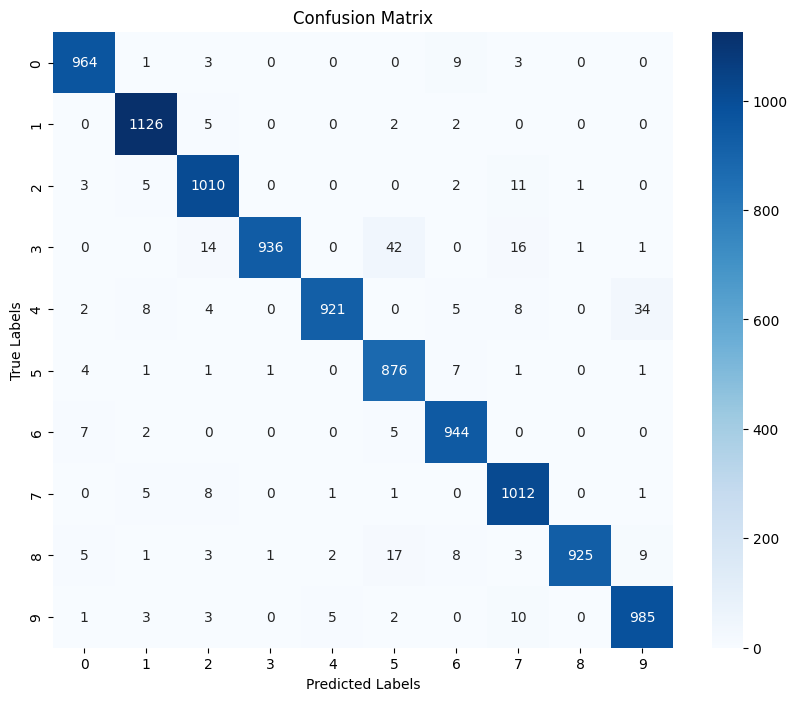

In [ ]:
import sklearn
import seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns


def compute_confusion_matrix(model, test_loader):
    model.eval()
    all_predicted = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predicted.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    conf_matrix = confusion_matrix(all_labels, all_predicted)
    return conf_matrix

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


conf_matrix = compute_confusion_matrix(nidhi, test_loader)
plot_confusion_matrix(conf_matrix)

In [ ]:
nidhi.eval()
total_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = nidhi(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss = total_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test
test_error = 100 - test_accuracy

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Error: {test_error:.2f}%")


Test Loss: 0.1077, Test Accuracy: 96.99%, Test Error: 3.01%


In [ ]:
def report_of_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params

    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")
    print(f"Non-Trainable Parameters: {non_trainable_params}")

report_of_parameters(nidhi)

Total Parameters: 4470
Trainable Parameters: 4470
Non-Trainable Parameters: 0



# Define the class mapping:


In [ ]:
import torch

class_mapping = {0: 0, 6: 0, 1: 1, 7: 1, 2: 2, 3: 2, 8: 2, 5: 2, 4: 3, 9: 3}

train_indices = [i for i, label in enumerate(train_labels) if label.item() in class_mapping]
train_images_2 = train_images[train_indices]
train_labels_2 = torch.tensor([class_mapping[label.item()] for label in train_labels[train_indices]], dtype=torch.long)

test_indices = [i for i, label in enumerate(test_labels) if label.item() in class_mapping]
test_images_2 = test_images[test_indices]
test_labels_2 = torch.tensor([class_mapping[label.item()] for label in test_labels[test_indices]], dtype=torch.long)

In [ ]:
train_images_2.shape,train_labels_2.shape,test_images_2.shape,test_labels_2.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([10000]))

In [ ]:
train_images_new= torch.tensor(train_images_2,dtype=torch.float32)
train_images_new=train_images_new/0.5
train_labels_new = torch.tensor(train_labels_2,dtype=torch.long)

test_images_new = torch.tensor(test_images_2,dtype=torch.float32)
test_images_new = test_images_new/0.5
test_labels_new =  torch.tensor(test_tags,dtype=torch.long)

train_images_4=train_images_new.reshape(60000,1,28,28)
train_labels_4=train_labels_new.reshape(60000)
test_images_4=test_images_new.reshape(10000,1,28,28)
test_labels_4=test_labels_new.reshape(10000)

split=int(len(train_images_4)*0.9)
train_images,train_labels=train_images_4[:split],train_labels_4[:split]
valid_images,valid_labels=train_images_4[split:],train_labels_4[split:]

train_dataset_2= TensorDataset(train_images, train_labels)
test_dataset_2 = TensorDataset(test_images, test_labels)
valid_dataset_2= TensorDataset(valid_images, valid_labels)

batch_size = 32

train_loader_2 = DataLoader(train_dataset_2, batch_size=batch_size, shuffle=True)
valid_loader_2 = DataLoader(valid_dataset_2, batch_size=batch_size, shuffle=False)
test_loader_2 = DataLoader(test_dataset_2, batch_size=batch_size, shuffle=False)

len(train_loader_2),len(test_loader_2),len(valid_dataset_2)

<ipython-input-19-b75597ddbfcc>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_images_new= torch.tensor(train_images_2,dtype=torch.float32)
<ipython-input-19-b75597ddbfcc>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_new = torch.tensor(train_labels_2,dtype=torch.long)
<ipython-input-19-b75597ddbfcc>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_images_new = torch.tensor(test_images_2,dtype=torch.float32)


(1688, 313, 6000)

In [ ]:
nidhi_2=MYY_CNN(4)
cal_parameters(nidhi_2)

(4368, 4368, 0)

In [ ]:
train_losses_2, train_accuracies_2, validation_losses_2, validation_accuracies_2 = train_and_validate(nidhi, criterion, optimizer, train_loader_2, valid_loader_2, epochs=15)

Epoch_no 1/15 - Train_Loss: 0.2454, Train_Acc: 93.13% - Validation_Loss: 0.0922, Validation_Acc: 97.20%
Epoch_no 2/15 - Train_Loss: 0.0822, Train_Acc: 97.36% - Validation_Loss: 0.0649, Validation_Acc: 98.23%
Epoch_no 3/15 - Train_Loss: 0.0666, Train_Acc: 97.89% - Validation_Loss: 0.1049, Validation_Acc: 96.80%
Epoch_no 4/15 - Train_Loss: 0.0571, Train_Acc: 98.15% - Validation_Loss: 0.0545, Validation_Acc: 98.43%
Epoch_no 5/15 - Train_Loss: 0.0498, Train_Acc: 98.42% - Validation_Loss: 0.0673, Validation_Acc: 98.08%
Epoch_no 6/15 - Train_Loss: 0.0454, Train_Acc: 98.58% - Validation_Loss: 0.0728, Validation_Acc: 97.68%
Epoch_no 7/15 - Train_Loss: 0.0444, Train_Acc: 98.64% - Validation_Loss: 0.0539, Validation_Acc: 98.52%
Epoch_no 8/15 - Train_Loss: 0.0420, Train_Acc: 98.66% - Validation_Loss: 0.0658, Validation_Acc: 98.20%
Epoch_no 9/15 - Train_Loss: 0.0391, Train_Acc: 98.77% - Validation_Loss: 0.0553, Validation_Acc: 98.60%
Epoch_no 10/15 - Train_Loss: 0.0351, Train_Acc: 98.86% - Validat

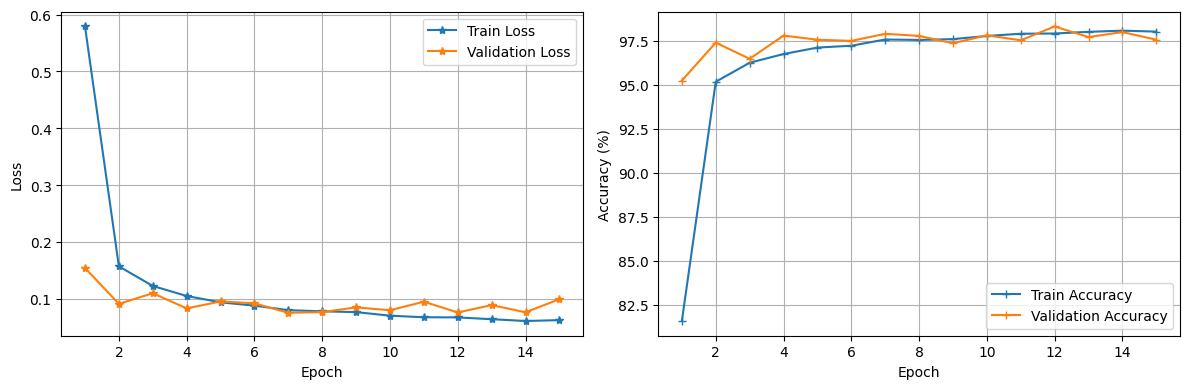

Sample Image Shape from Test Loader: torch.Size([32, 1, 28, 28])


In [ ]:

analysis_model(nidhi_2, train_losses, validation_losses, train_accuracies, validation_accuracies, test_loader_2, epochs=15)


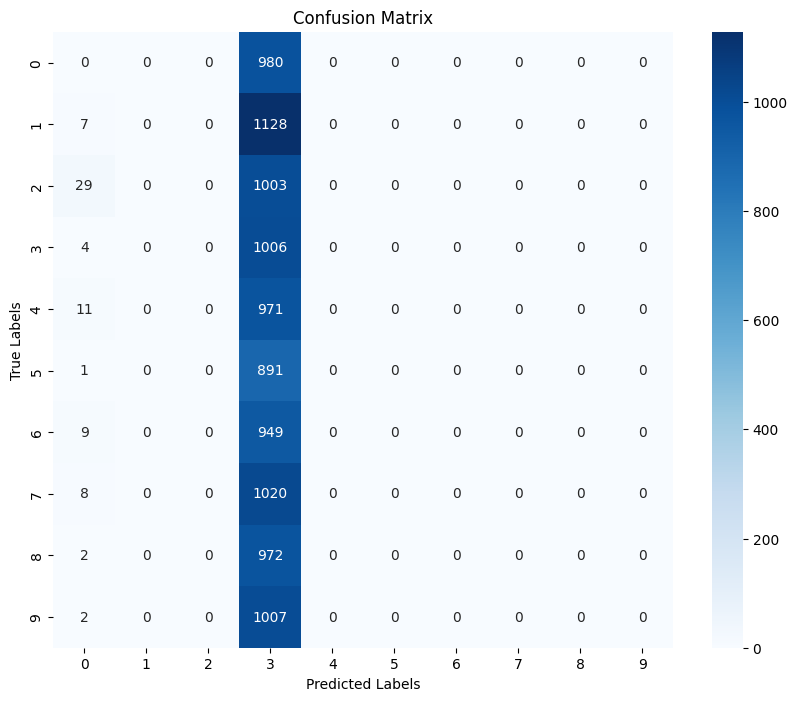

In [ ]:
conf_matrix_2= compute_confusion_matrix(nidhi_2, test_loader_2)
plot_confusion_matrix(conf_matrix_2)

In [ ]:
nidhi.eval()
total_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = nidhi(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss = total_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test
test_error = 100 - test_accuracy

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Error: {test_error:.2f}%")


Test Loss: 15.8921, Test Accuracy: 31.03%, Test Error: 68.97%


In [ ]:
class New_CNN(nn.Module):
    def __init__(self, num_classes):
        super(MYY_CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(4)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc = nn.Linear(4 * 4, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.avgpool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0),-1)
        x = self.fc(x)

        return x
